In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from glob import glob
from torch import nn, optim

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin","miami" ,"pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    elif split=="test":
        f_in = ROOT_PATH + "test" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        outputs = pickle.load(open(ROOT_PATH + 'train' + "/" + city + "_outputs", "rb")) #this isnt actually used
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [3]:
for i in range(1,len(cities)):
    train_dataset2=ArgoverseDataset(city = cities[i], split = split)
    train_dataset=train_dataset+train_dataset2

In [4]:
val_dataset = ArgoverseDataset(city = city, split = 'val')

In [5]:
for i in range(1,len(cities)):
    val_dataset2=ArgoverseDataset(city = cities[i], split = split)
    val_dataset=val_dataset+val_dataset2

In [6]:
len(val_dataset)

131018

In [7]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz,shuffle=False)

In [8]:
def fitData(x, y, transform="MinMax"):
    if transform == 'MinMax':
        scaler = MinMaxScaler()
    elif transform == "Standard":
        scaler = StandardScaler()
    else:
        return x, y

    scaler.fit(x.reshape(-1, 2))
    scaler.fit(y.reshape(-1, 2))
    x_ = scaler.transform(x.reshape(-1, 2)).reshape(-1, 50, 2)
    y_ = scaler.transform(y.reshape(-1, 2)).reshape(-1, 60, 2)

    return x_, y_, scaler

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:0')
input_size = 2
hidden_size = 256
output_size = 60
batch_size = 4
n_layers = 2
seq_len = 50
epochs = 11

In [10]:
import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.MaxPool1d(4)
        self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
        self.p2 = nn.MaxPool1d(5)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.shape[0]
        

        # Run through Conv1d and Pool1d layers
        c = self.c1(inputs).to(device)
        p = self.p1(c).to(device)
        c = self.c2(p).to(device)
        p = self.p2(c).to(device)
        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(1, 2).transpose(0, 1).to(device)
        
        p = F.relu(p)#.to(device)
        output, hidden = self.lstm(p, hidden)
        conv_seq_len = output.shape[0]
        output = output.view(conv_seq_len * batch_size, self.hidden_size).to(device) # Treating (conv_seq_len x batch_size) as batch_size for linear layer
#         output = torch.tanh(self.out(output))
        output = self.out(output).to(device)
        output = output.view( -1, self.output_size, conv_seq_len).to(device)
        return output, hidden

In [11]:
rnn = RNN(input_size, hidden_size, output_size, n_layers=n_layers).to(device)
optimizer = optim.Adam(rnn.parameters(), lr = 0.01)
lossFunction = nn.MSELoss().to(torch.float32)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0 loss: 20.502850821111835
epoch 1 loss: 20.475154080307128


Text(0, 0.5, 'Loss')

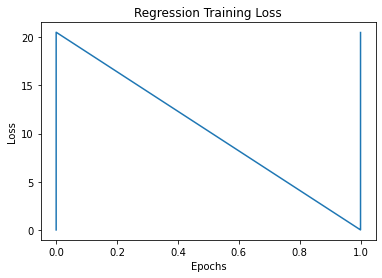

In [12]:
import matplotlib.pyplot as plt
epochs=[]
losses=[]
for epoch in range(2):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        inp, out, scaler = fitData(inp, out, 'MinMax')
        inp=torch.from_numpy(inp)
        out=torch.from_numpy(out)
        inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32)
        #print(inp.shape)
        preds,hidden = rnn(inp.transpose(1,2).float(), None)
        #print(preds.shape)
        #print(out.shape)
        loss = ((preds - out) ** 2).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        epochs.append(epoch)
        losses.append(total_loss / len(train_dataset))
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))
plt.plot(epochs,losses)
plt.title("Regression Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [13]:
val_loader = DataLoader(val_dataset,batch_size=batch_sz,shuffle=True)

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    inp, out, scaler = fitData(inp, out, 'MinMax')
    inp=torch.from_numpy(inp)
    out=torch.from_numpy(out)
    inp, out = inp.to(device).to(torch.float32), out.to(device).to(torch.float32)
    #print(inp.shape)
    preds,hidden = rnn(inp.transpose(1,2).float(), None)
    #print(preds.shape)
    #print(out.shape)
    loss = ((preds - out) ** 2).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    val_loss += loss.item()
print('loss: {}'.format(val_loss / len(val_dataset)))

loss: 19.75657613678251
